## Data Augmentation

In [1]:
import cv2
import h5py
import numpy as np
from matplotlib import pyplot as plt

# import our package
from torch_connectomics.data.augmentation import *

### 1. Load data

For Harvard Research Computing (RC) cluster users, you can directly access the dsta directory if you have access to the `coxfs01` partition. For external users please check the tutotial for downloading the dataset and change the `data_path` accordingly.

In [2]:
data_path = '/n/coxfs01/zudilin/data/SNEMI3D/'
image_path = data_path + 'train_image.h5'
label_path = data_path + 'train_label.h5'
image = np.array(h5py.File(image_path, 'r')['main'])
label = np.array(h5py.File(label_path, 'r')['main'])
print(image.shape, image.ndim, image.dtype)
print(label.shape, label.ndim, label.dtype)

(100, 1024, 1024) 3 uint8
(100, 1024, 1024) 3 uint16


In [3]:
def show_imgs(imgs, label=None, cmap=None):
    plt.figure(figsize=(16,4))
    for i in range(1,5):
        plt.subplot('14%d' % (i))
        if cmap is not None:
            plt.imshow(imgs[i-1], cmap=cmap)
        else:
            plt.imshow(imgs[i-1])
        if label is not None:
            plt.title(label+' '+str(i))
    plt.show()

### 2. Show image and segmentation

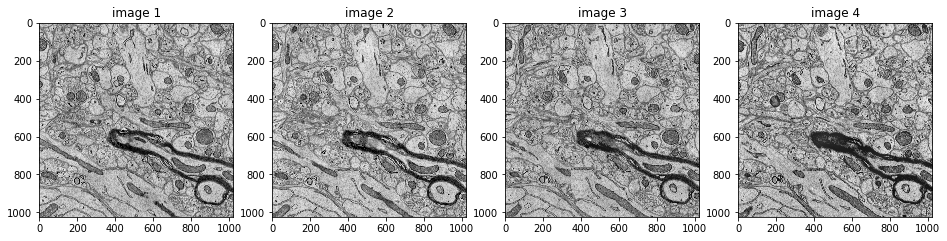

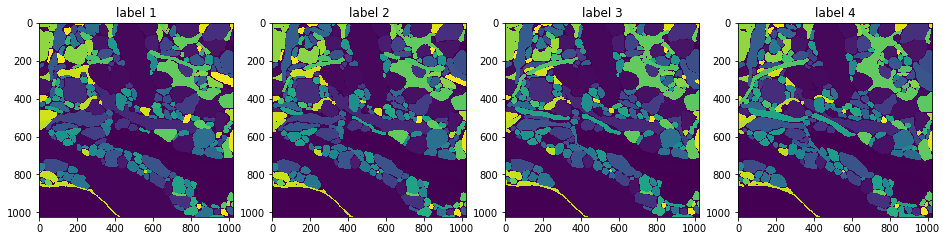

In [4]:
show_imgs(image[0:5], label='image', cmap='gray')
show_imgs(label[0:5], label='label')

### 3. Construct data augmentor

In [5]:
augmentor = Compose([Rotate(p=1.0),
                     Rescale(p=1.0),
                     Flip(p=0.0),
                     Elastic(alpha=10.0, p=0.5),
                     MissingParts(p=0.8),
                     MisAlignment(p=0.8),
                     MissingSection(p=0.5),
                     Grayscale()], 
                     input_size = (8,160,160),
                     keep_non_smoothed = True)
# Keep also the non-smoothed segmentation label
# here only for illustration purpose.
print(augmentor.sample_size)

Sample size required for the augmentor: [ 12 339 339]
[ 12 339 339]


### 4. Sample volumes from the image stack

In [6]:
random_state = np.random.RandomState(7)
z = random_state.randint(label.shape[0]-augmentor.sample_size[0])
y = random_state.randint(label.shape[1]-augmentor.sample_size[1])
x = random_state.randint(label.shape[2]-augmentor.sample_size[2])
test_image = image[z:z+augmentor.sample_size[0], 
                   y:y+augmentor.sample_size[1],
                   x:x+augmentor.sample_size[2]]/255.0
test_image = test_image.astype(np.float32)
test_label = label[z:z+augmentor.sample_size[0], 
                   y:y+augmentor.sample_size[1],
                   x:x+augmentor.sample_size[2]]
print(test_image.shape, test_image.ndim, test_image.dtype)
print(test_label.shape, test_label.ndim, test_label.dtype)

(12, 339, 339) 3 float32
(12, 339, 339) 3 uint16


### 5. Apply data augmentation

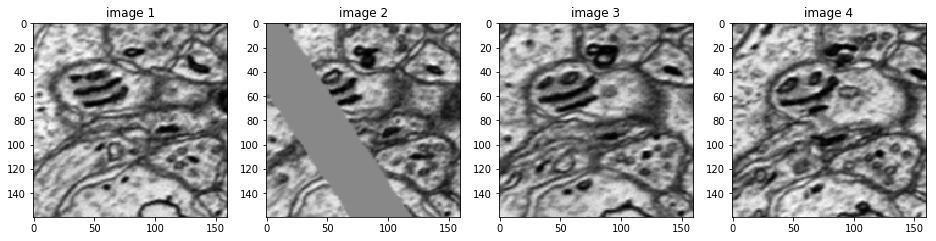

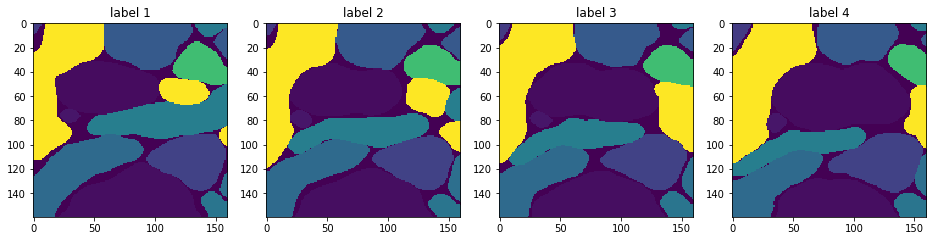

In [7]:
data = {}
data['image']=test_image
data['label']=test_label
augmented = augmentor(data, random_state=np.random.RandomState(976))
show_imgs(augmented['image'][0:4], 'image', cmap='gray')
show_imgs(augmented['label'][0:4], 'label')

### 6. Show the effect of smoothing border
The segmentation masks processed by the augmentor can have aliasing artifacts along the borders caused by nearest interpolation. Here we use Gaussian filters and dilation operation to smooth the borders while preserving the shape and size.

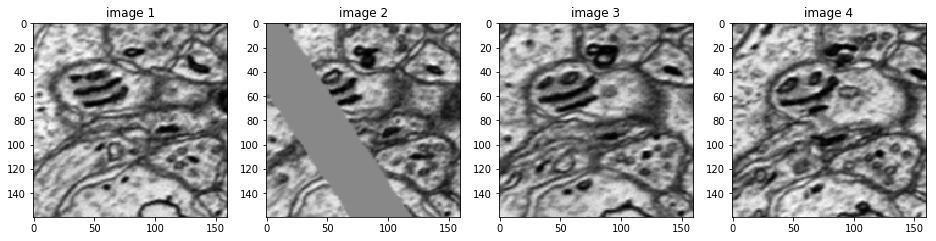

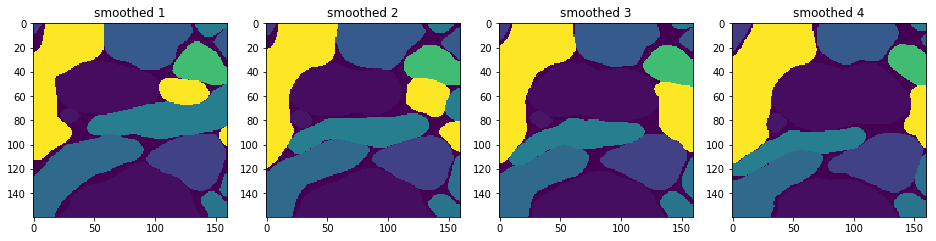

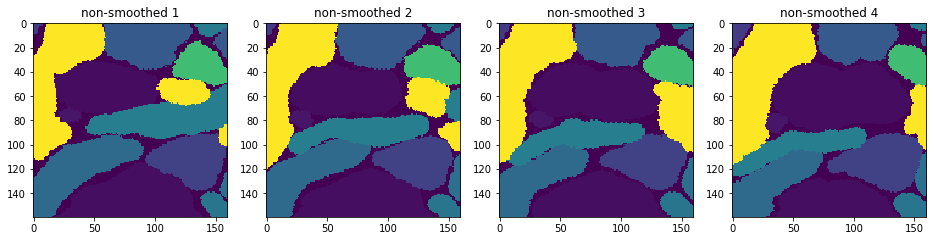

In [8]:
show_imgs(augmented['image'][0:4], 'image', cmap='gray')
show_imgs(augmented['label'][0:4], 'smoothed')
show_imgs(augmented['non_smoothed'][0:4], 'non-smoothed')

### 7. Other augmentation methods
Feel free to play with other kinds of data augmentation methods (e.g. motion blur) here. Generally the data augmentation methods included in the Pytorch Connectomics package come from real EM image artifacts caused by imageing or sample preparation.

In [9]:
def motion_blur(imgs):
    transformed = imgs.copy()
    size = 11

    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    
    for img_id in range(transformed.shape[0]):
        # applying the kernel to the input image
        transformed[img_id] = cv2.filter2D(transformed[img_id], -1, kernel_motion_blur)
        
    return transformed

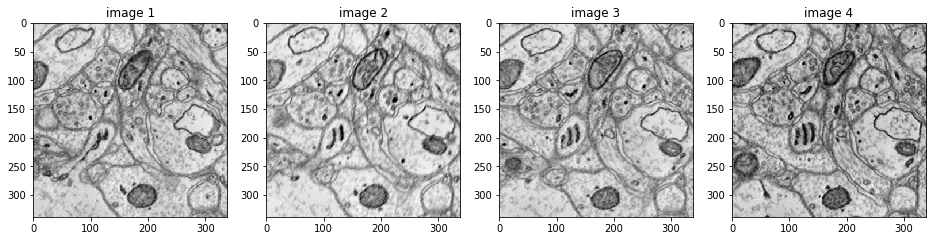

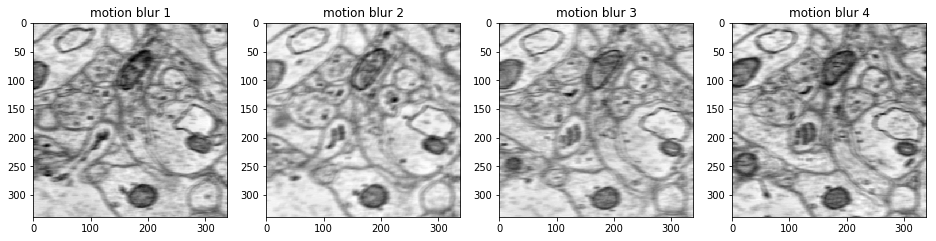

In [10]:
show_imgs(test_image[0:4], 'image',  cmap='gray')
show_imgs(motion_blur(test_image[0:4]), 'motion blur', cmap='gray')